In [1]:
%%capture
!pip install --user shap

In [2]:
import os
import ipywidgets as widgets
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
import keras
import keras.backend as k
import keras.models
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import warnings
from ROOT import TMVA, TFile, TTree, TCut, TRandom3
import varsList
warnings.simplefilter("ignore")

Using TensorFlow backend.


Welcome to JupyROOT 6.20/06


In [3]:
print("Tensorflow version {}".format(tf.__version__))
print("Keras version {}".format(keras.__version__))

Tensorflow version 1.14.0
Keras version 2.2.4


In [4]:
dirList = next(os.walk(os.getcwd()))[1]
sampleDir = widgets.Dropdown( options = dirList )
sampleDir

Dropdown(options=('.git', '.sys.v#.Correlation Consideration.ipynb', '.sys.v#.Correlation Pandas.ipynb', '.sys…

In [34]:
sigSample = widgets.Dropdown( options = os.listdir( sampleDir.value ) )
sigSample

Dropdown(options=('TTTT_TuneCP5_PSweights_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_PSweights_13Te…

In [35]:
bkgSamples = widgets.SelectMultiple( options = os.listdir( sampleDir.value ) )
bkgSamples

SelectMultiple(options=('TTTT_TuneCP5_PSweights_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_PSweight…

In [36]:
sigFile = TFile.Open( sampleDir.value + "/" + sigSample.value )
bkgFiles = {}
for file in bkgSamples.value:
    bkgFiles[file] = TFile.Open( sampleDir.value + "/" + file )

In [37]:
sigTree = sigFile.Get( "ljmet" )
bkgTrees = {}
for file in bkgSamples.value:
    bkgTrees[file] = bkgFiles[file].Get( "ljmet" )

In [38]:
cutVars = [
    "leptonPt_MultiLepCalc","isElectron","isMuon","corr_met_MultiLepCalc","MT_lepMet",
    "minDR_lepJet","AK4HT","DataPastTriggerX","MCPastTriggerX","NJetsCSVwithSF_MultiLepCalc",
    "NJets_JetSubCalc","triggerXSF","pileupWeight","lepIdSF","EGammaGsfSF","isoSF",
    "L1NonPrefiringProb_CommonCalc","xsecEff","MCWeight_MultiLepCalc"
]

leptonPt = 50.
isElectron = 1
isMuon = 1
corr_met = 60.
MT_lepMet = 60.
minDR_lepJet = 0.4
AK4HT = 510.
DataPastTriggerX = 1
MCPastTriggerX = 1
bJets = 2
nJets = 6

In [39]:
sigCut = np.asarray(
    sigTree.AsMatrix( cutVars )
)

bkgCut = {}

for file in bkgSamples.value:
    bkgCut[file] = np.asarray(
        bkgTrees[file].AsMatrix( cutVars )
    )

In [40]:
bkgCutComb = np.concatenate([bkgCut[file] for file in bkgSamples.value])

In [41]:
sigCutSort = sigCut[np.lexsort((sigCut[:,3],sigCut[:,0]))]
bkgCutSort = bkgCutComb[np.lexsort((bkgCutComb[:,3],bkgCutComb[:,0]))]

In [42]:
sigMask = np.zeros(np.shape(sigCutSort)[0])
bkgMask = np.zeros(np.shape(bkgCutSort)[0])
for i in range(np.shape(sigCutSort)[0]):
    if( ( sigCutSort[i,0] > leptonPt and sigCutSort[i,1] == isElectron ) or ( sigCutSort[i,0] > leptonPt and sigCutSort[i,2] == isMuon ) ):
        if( sigCutSort[i,3] > corr_met and sigCutSort[i,4] > MT_lepMet and sigCutSort[i,5] > minDR_lepJet and sigCutSort[i,6] > AK4HT ):
            if( sigCutSort[i,7] == DataPastTriggerX and sigCutSort[i,8] == MCPastTriggerX ):
                if( sigCutSort[i,9] >= bJets and sigCutSort[i,10] >= nJets ):
                    sigMask[i] = 1
for i in range(np.shape(bkgCutSort)[0]):
    if( ( bkgCutSort[i,0] > leptonPt and bkgCutSort[i,1] == isElectron ) or ( bkgCutSort[i,0] > leptonPt and bkgCutSort[i,2] == isMuon ) ):
        if( bkgCutSort[i,3] > corr_met and bkgCutSort[i,4] > MT_lepMet and bkgCutSort[i,5] > minDR_lepJet and bkgCutSort[i,6] > AK4HT ):
            if( bkgCutSort[i,7] == DataPastTriggerX and bkgCutSort[i,8] == MCPastTriggerX ):
                if( bkgCutSort[i,9] >= bJets and bkgCutSort[i,10] >= nJets ):
                    bkgMask[i] = 1

In [43]:
varList = np.asarray(varsList.varList["DNN"])[:,0]

sigEvents = np.asarray(
    sigTree.AsMatrix( varList )
)

bkgEvents = {}

for file in bkgSamples.value:
    bkgEvents[file] = np.asarray(
        bkgTrees[file].AsMatrix( varList )
    )
    
bkgEventsComb = np.concatenate([bkgEvents[file] for file in bkgSamples.value])

In [44]:
indx1 = np.argwhere(varList == "leptonPt_MultiLepCalc")[0,0]
indx2 = np.argwhere(varList == "corr_met_MultiLepCalc")[0,0]

In [45]:
sigEventsSort = sigEvents[np.lexsort((sigEvents[:,indx2],sigEvents[:,indx1]))]
bkgEventsSort = bkgEventsComb[np.lexsort((bkgEventsComb[:,indx2],bkgEventsComb[:,indx1]))]

In [46]:
sigEventsCut = np.asarray(sigEventsSort)[sigMask.astype(bool)]
bkgEventsCut = np.asarray(bkgEventsSort)[bkgMask.astype(bool)]

In [47]:
sigLabels = np.full((np.shape(sigEventsCut)[0]),[1]).astype("bool")
bkgLabels = np.full((np.shape(bkgEventsCut)[0]),[0]).astype("bool")

In [48]:
y_all = np.concatenate((sigLabels,bkgLabels))
x_all = np.concatenate((sigEventsCut,bkgEventsCut))

In [49]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all,
    test_size = 0.3
)

In [50]:
tf.Session().run(tf.global_variables_initializer())

In [51]:
k.clear_session()
model = Sequential()
model.add(Dense(
    50,
    input_dim = x_all.shape[1],
    kernel_initializer = "glorot_normal",
    activation = "relu"
))
model.add(BatchNormalization())
model.add(Dense(
    50,
    kernel_initializer = "glorot_normal",
    activation = "relu"
))
model.add(BatchNormalization())
model.add(Dense(
    1,
    activation = "sigmoid"
))
model.compile(
    optimizer = Adam(lr = 1e-3),
    #loss = "categorical_crossentropy",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                3850      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 6,851
Trainable params: 6,651
Non-trainable params: 200
_________________________________________________________________


In [52]:
model_checkpoint = ModelCheckpoint(
    "SHAP_model.h5",
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = "auto",
    period = 1
)

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5
)

In [53]:
history = model.fit(
    np.array(x_train), np.array(y_train),
    epochs = 15,
    batch_size = 2**9,
    shuffle = True,
    verbose = 1,
    callbacks = [early_stopping, model_checkpoint],
    validation_split = 0.25
)

Train on 320502 samples, validate on 106835 samples
Epoch 1/15
320502/320502 [==============================] - 4s 13us/step - loss: 0.3700 - acc: 0.8500 - val_loss: 0.3318 - val_acc: 0.8668
Epoch 2/15
320502/320502 [==============================] - 3s 9us/step - loss: 0.3207 - acc: 0.8699 - val_loss: 0.3324 - val_acc: 0.8627
Epoch 3/15
320502/320502 [==============================] - 3s 10us/step - loss: 0.3116 - acc: 0.8730 - val_loss: 0.3187 - val_acc: 0.8683
Epoch 4/15
320502/320502 [==============================] - 4s 11us/step - loss: 0.3060 - acc: 0.8753 - val_loss: 0.3055 - val_acc: 0.8761
Epoch 5/15
320502/320502 [==============================] - 4s 12us/step - loss: 0.3024 - acc: 0.8771 - val_loss: 0.3073 - val_acc: 0.8744
Epoch 6/15
320502/320502 [==============================] - 4s 11us/step - loss: 0.2996 - acc: 0.8778 - val_loss: 0.3276 - val_acc: 0.8687
Epoch 7/15
320502/320502 [==============================] - 4s 12us/step - loss: 0.2972 - acc: 0.8791 - val_loss: 0

In [54]:
model = keras.models.load_model("SHAP_model.h5")

def f(x):
    return model.predict(x).flatten()

In [55]:
predictions = model.predict(x_test)

In [56]:
fpr, tpr, _ = roc_curve(y_test.astype(int), predictions[:,0])
AUC = auc(fpr,tpr)

In [57]:
x_kmeans = shap.kmeans(x_train,100)
explainer = shap.KernelExplainer(f, x_kmeans)

In [58]:
shap_values = explainer.shap_values(x_test[:50000], nsamples=10)

In [59]:
colorRank = []
shapMean = np.mean(np.asarray(shap_values),axis=0)
shapAbsMean = np.mean(abs(np.asarray(shap_values)),axis=0)
shapStd = np.std((np.asarray(shap_values)),axis=0)
shapAbsStd = np.std(abs(np.asarray(shap_values)),axis=0)

for i, var in enumerate(varList):
    if shapMean[i] > 0: colorRank.append("green")
    else: colorRank.append("blue")
        
shapAbsMean_sort, shapAbsStd_sort, colorRankAbs_sort, varListAbs_sort = zip(*sorted(zip(
    shapAbsMean, shapAbsStd, colorRank, varList
)))

shapMean_sort, shapStd_sort, colorRank_sort, varList_sort = zip(*sorted(zip(
    shapMean, shapStd, colorRank, varList
)))

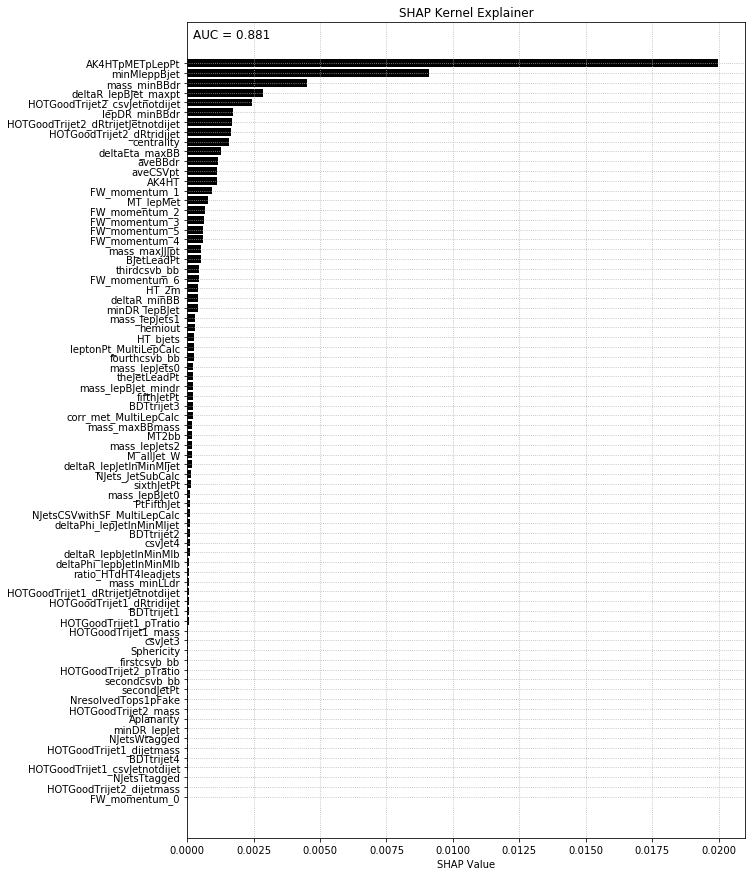

In [60]:
plt.figure(figsize=(10,int(len(varList_sort)/5)))
plt.barh(
    varList_sort,shapMean_sort,color="black",
    align="center",capsize=5.0)
plt.title("SHAP Kernel Explainer")
plt.xlabel("SHAP Value")
plt.grid(which = "both", linestyle = ":")
plt.annotate(
    "AUC = {:.3f}".format(AUC),
    xycoords = "axes pixels",
    xy = (6,800),
    fontsize = 12
)
plt.show()

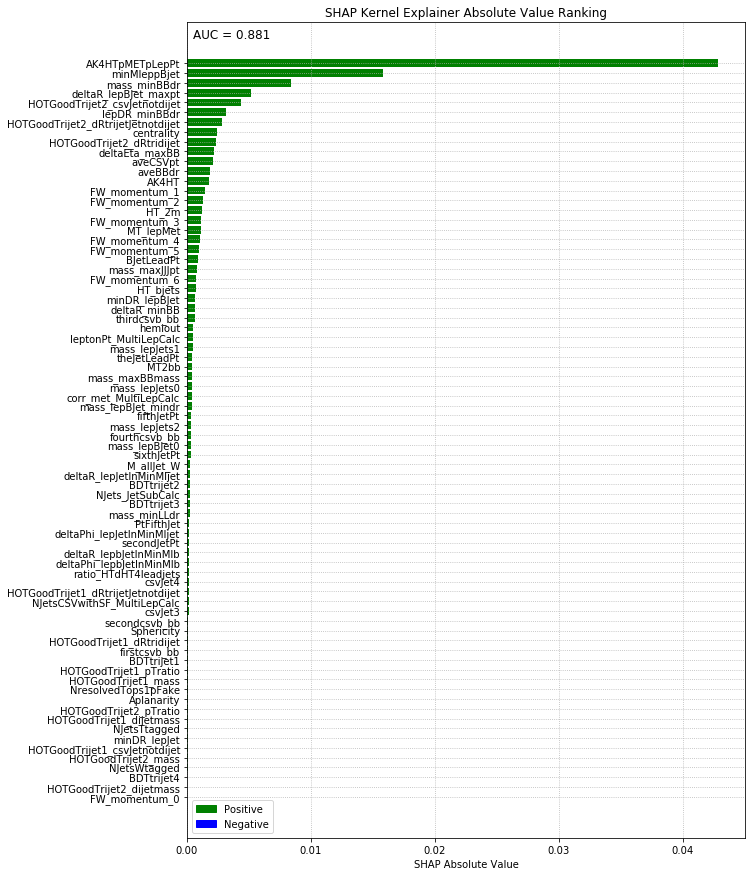

In [61]:
plt.figure(figsize=(10,int(len(varList_sort)/5)))
plt.barh(
    varListAbs_sort,shapAbsMean_sort,color=colorRankAbs_sort,
    align="center",capsize=5.0)
plt.title("SHAP Kernel Explainer Absolute Value Ranking")
plt.xlabel("SHAP Absolute Value")
plt.grid(which = "both", linestyle = ":")
green_patch = mpatches.Patch(color="green",label="Positive")
blue_patch = mpatches.Patch(color="blue",label="Negative")
plt.legend(loc="best",handles=[green_patch,blue_patch])
plt.annotate(
    "AUC = {:.3f}".format(AUC),
    xycoords = "axes pixels",
    xy = (6,800),
    fontsize = 12
)
plt.show()